# Debugging doubly-periodic dycore

## Configuration

Taking configuration from a yaml_file, so just need to provide its path

In [1]:
config_path = '../pace/driver/examples/configs/rce_c12_dp.yaml'

## Initialize MPI cluster

Note: need to be careful not to re-run these cells before shutting down the cluster they create.

In [2]:
# %autopx
# cluster.shutdown()

In [3]:
import ipyparallel as ipp

# spinup cluster of MPI-workers
num_ranks = 9
cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "config_path": config_path
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 9 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.63engine/s]
%autopx enabled


In [4]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

print(f"I am MPI-rank {mpi_rank} of a total of {mpi_size}")

[stdout:7] I am MPI-rank 7 of a total of 9


[stdout:1] I am MPI-rank 1 of a total of 9


[stdout:0] I am MPI-rank 0 of a total of 9


[stdout:2] I am MPI-rank 2 of a total of 9


[stdout:8] I am MPI-rank 8 of a total of 9


[stdout:5] I am MPI-rank 5 of a total of 9


[stdout:3] I am MPI-rank 3 of a total of 9


[stdout:4] I am MPI-rank 4 of a total of 9


[stdout:6] I am MPI-rank 6 of a total of 9


## Create driver for doubly-periodic RCE simulation

`%%capture` magic suppressess output that breaks jupyterlab color theme in vscode.

In [5]:
%%capture

import yaml
from pace.driver import Driver, DriverConfig

with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    driver_config = DriverConfig.from_dict(config)

driver = Driver(config=driver_config)

%px: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/tasks]


## Create utilities for plotting dycore state

In [6]:
if mpi_rank == 0:
    print(list(driver.state.dycore_state.__dict__.keys()))

[stdout:0] ['u', 'v', 'w', 'ua', 'va', 'uc', 'vc', 'delp', 'delz', 'ps', 'pe', 'pt', 'peln', 'pk', 'pkz', 'qvapor', 'qliquid', 'qice', 'qrain', 'qsnow', 'qgraupel', 'qo3mr', 'qsgs_tke', 'qcld', 'q_con', 'omga', 'mfxd', 'mfyd', 'cxd', 'cyd', 'diss_estd', 'phis', 'bdt', 'mdt']


In [7]:
import matplotlib.pyplot as plt 
plt.rc("font", size=8)
from pace.util import TileCommunicator

vars = ["u", "v", "w", "pt"]
where = ["dycore", "dycore", "dycore", "dycore"]

def lookup(driver, var, loc):
    if loc == "dycore":
        return getattr(driver.state.dycore_state, var)
    if loc == "acoustic_solver":
        return getattr(driver.dycore.acoustic_dynamics, var)

def plot_data(driver, k=10):
    fig, axes = plt.subplots(
        figsize=(2*len(vars), 3), nrows=1, ncols=len(vars), 
        sharex=False, sharey=False, constrained_layout=True
    )
    for i, (var, loc) in enumerate(zip(vars, where)):
        im = axes[i].imshow(lookup(driver, var, loc).data[:-1,:-1,k])
        axes[i].set_title(var, fontsize=8)

def plot_view(driver, k=10):
    fig, axes = plt.subplots(
        figsize=(2*len(vars), 3), nrows=1, ncols=len(vars), 
        sharex=False, sharey=False, constrained_layout=True
    )
    for i, (var, loc) in enumerate(zip(vars, where)):
        im = axes[i].imshow(lookup(driver, var, loc).view[:,:,k])
        axes[i].set_title(var, fontsize=8)

def gather_plot_data(driver, k=10):
    communicator = TileCommunicator.from_layout(
        comm=driver.comm,
        layout=driver.config.layout
    )
    if mpi_rank == 0:
        fig, axes = plt.subplots(
            figsize=(2*len(vars), 3), nrows=1, ncols=len(vars), 
            sharex=False, sharey=False, constrained_layout=True
        )
    for i, (var, loc) in enumerate(zip(vars, where)):
        global_var = communicator.gather(lookup(driver, var, loc))
        if mpi_rank == 0:
            im = axes[i].imshow(global_var.data[...,k])
            axes[i].set_title(var, fontsize=8)

def plot_all(driver, target_rank=0, k=10):
    if mpi_rank == target_rank:
        plot_data(driver, k=k)
        plot_view(driver, k=k)
    gather_plot_data(driver, k=k)

Plot initial condition

[output:0]

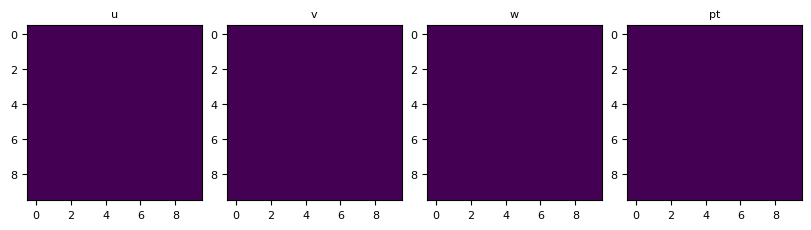

[output:0]

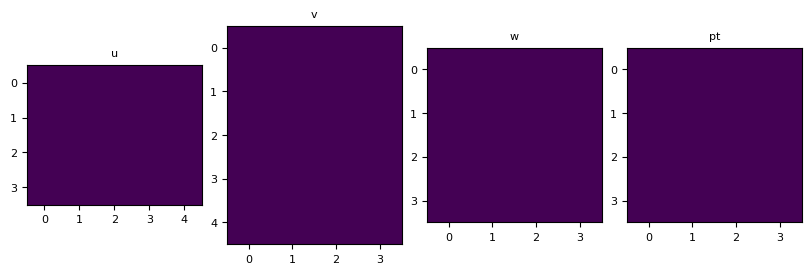

[output:0]

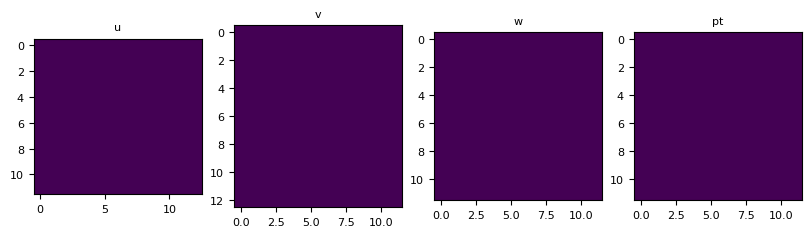

In [8]:
plot_all(driver)

## Step dynamical core forward and plot state along the way

### Inside `_compute`

In [9]:
self = driver.dycore
state = driver.state.dycore_state

last_step = False
self.compute_preamble(
    state,
    is_root_rank=driver.dycore.comm_rank == 0
)

### Inside dynamics substep (`k_split`)

In [10]:
k_split = 0 
n_map = k_split + 1
last_step = k_split == self._k_split - 1

self._copy_stencil(
    state.delp,
    self._dp_initial
)

### Inside `acoustic_dynamics`:

In [11]:
state = state
timestep = driver.dycore._timestep / driver.dycore._k_split
n_map = n_map

self = driver.dycore.acoustic_dynamics


# u, v, w, delz, delp, pt, pe, pk, phis, wsd, omga, ua, va, uc, vc, mfxd,
# mfyd, cxd, cyd, pkz, peln, q_con, ak, bk, diss_estd, cappa, mdt, n_split,
# akap, ptop, n_map, comm):
end_step = n_map == self.config.k_split
# dt = state.mdt / self.config.n_split
dt_acoustic_substep = self.dt_acoustic_substep(timestep)
dt2 = self.dt2(dt_acoustic_substep)
n_split = self.config.n_split
# NOTE: In Fortran model the halo update starts happens in fv_dynamics, not here
self._halo_updaters.q_con__cappa.start()
self._halo_updaters.delp__pt.start()
self._halo_updaters.u__v.start()
self._halo_updaters.q_con__cappa.wait()

self._zero_data(
    state.mfxd,
    state.mfyd,
    state.cxd,
    state.cyd,
    self._heat_source,
    state.diss_estd,
    n_map == 1,
)

### Inside acoustic loop (`n_split`)

In [12]:
# Following code is normally inside the acoustic loop
it = 0

remap_step = False
if self.config.breed_vortex_inline or (it == n_split - 1):
    remap_step = True
if not self.config.hydrostatic:
    self._halo_updaters.w.start()
    if it == 0:
        self._gz_from_surface_height_and_thickness(
            self._zs,
            state.delz,
            self._gz,
        )
        self._halo_updaters.gz.start()
if it == 0:
    self._halo_updaters.delp__pt.wait()

if it == n_split - 1 and end_step:
    if self.config.use_old_omega:
        self._interface_pressure_from_toa_pressure_and_thickness(
            state.delp,
            self._pem,
            self._ptop,
        )

self._halo_updaters.u__v.wait()
if not self.config.hydrostatic:
    self._halo_updaters.w.wait()

# compute the c-grid winds at t + 1/2 timestep
self._checkpoint_csw(state, tag="In")
self.cgrid_shallow_water_lagrangian_dynamics(
    state.delp,
    state.pt,
    state.u,
    state.v,
    state.w,
    state.uc,
    state.vc,
    state.ua,
    state.va,
    self._ut,
    self._vt,
    self._divgd,
    state.omga,
    dt2,
)
self._checkpoint_csw(state, tag="Out")

# TODO: Computing the pressure gradient outside of C_SW was originally done
# so that we could transpose into a vertical-first memory ordering for the
# gz computation, now that we have gt4py we should pull this into C_SW.
if self.config.nord > 0:
    self._halo_updaters.divgd.start()
if not self.config.hydrostatic:
    # TODO: is there some way we can avoid aliasing gz and zh, so that
    # gz is always a geopotential and zh is always a height?
    if it == 0:
        self._halo_updaters.gz.wait()
        self._copy_stencil(
            self._gz,
            self._zh,
        )
    else:
        self._copy_stencil(
            self._zh,
            self._gz,
        )
if not self.config.hydrostatic:
    self.update_geopotential_height_on_c_grid(
        self._zs, self._ut, self._vt, self._gz, self._ws3, dt2
    )
    # TODO (floriand): Due to DaCe VRAM pooling creating a memory
    # leak with the usage pattern of those two fields
    # We use the C_SW internal to workaround it e.g.:
    #  - self.cgrid_shallow_water_lagrangian_dynamics.delpc
    #  - self.cgrid_shallow_water_lagrangian_dynamics.ptc
    # DaCe has already a fix on their side and it awaits release
    # issue
    self.vertical_solver_cgrid(
        dt2,
        self.cappa,
        self._ptop,
        state.phis,
        self._ws3,
        self.cgrid_shallow_water_lagrangian_dynamics.ptc,
        state.q_con,
        self.cgrid_shallow_water_lagrangian_dynamics.delpc,
        self._gz,
        self._pkc,
        state.omga,
    )

self._p_grad_c(
    self.grid_data.rdxc,
    self.grid_data.rdyc,
    state.uc,
    state.vc,
    self.cgrid_shallow_water_lagrangian_dynamics.delpc,
    self._pkc,
    self._gz,
    dt2,
)

self._halo_updaters.uc__vc.start()
if self.config.nord > 0:
    self._halo_updaters.divgd.wait()
self._halo_updaters.uc__vc.wait()
# use the computed c-grid winds to evolve the d-grid winds forward
# by 1 timestep
self._checkpoint_dsw_in(state)
self.dgrid_shallow_water_lagrangian_dynamics(
    self._vt,
    state.delp,
    state.pt,
    state.u,
    state.v,
    state.w,
    state.uc,
    state.vc,
    state.ua,
    state.va,
    self._divgd,
    state.mfxd,
    state.mfyd,
    state.cxd,
    state.cyd,
    self._crx,
    self._cry,
    self._xfx,
    self._yfx,
    state.q_con,
    self._zh,
    self._heat_source,
    state.diss_estd,
    dt_acoustic_substep,
)
self._checkpoint_dsw_out(state)
# note that uc and vc are not needed at all past this point.
# they will be re-computed from scratch on the next acoustic timestep.

self._halo_updaters.delp__pt__q_con.update()

# Not used unless we implement other betas and alternatives to nh_p_grad
# if self.namelist.d_ext > 0:
#    raise 'Unimplemented namelist option d_ext > 0'

# TODO: should the dycore have hydrostatic and non-hydrostatic modes,
# or would we make a new class for the non-hydrostatic mode?
if not self.config.hydrostatic:
    # without explicit arg names, numpy does not run
    self.update_height_on_d_grid(
        surface_height=self._zs,
        height=self._zh,
        courant_number_x=self._crx,
        courant_number_y=self._cry,
        x_area_flux=self._xfx,
        y_area_flux=self._yfx,
        ws=self._wsd,
        dt=dt_acoustic_substep,
    )
    self.vertical_solver(
        remap_step,
        dt_acoustic_substep,
        self.cappa,
        self._ptop,
        self._zs,
        self._wsd,
        state.delz,
        state.q_con,
        state.delp,
        state.pt,
        self._zh,
        state.pe,
        self._pkc,
        self._pk3,
        state.pk,
        state.peln,
        state.w,
    )

    self._halo_updaters.zh.start()
    self._halo_updaters.pkc.start()
    if remap_step:
        # TODO: can this be moved to the start of the remapping routine?
        self._edge_pe_stencil(state.pe, state.delp, self._ptop)
    if self.config.use_logp:
        raise NotImplementedError(
            "unimplemented namelist option use_logp=True"
        )
    else:
        self._pk3_halo(self._pk3, state.delp, self._ptop, self._akap)

[output:0]

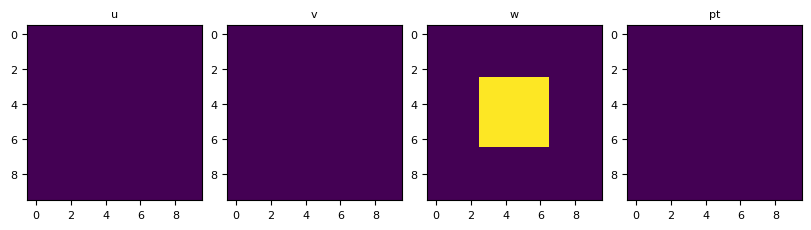

[output:0]

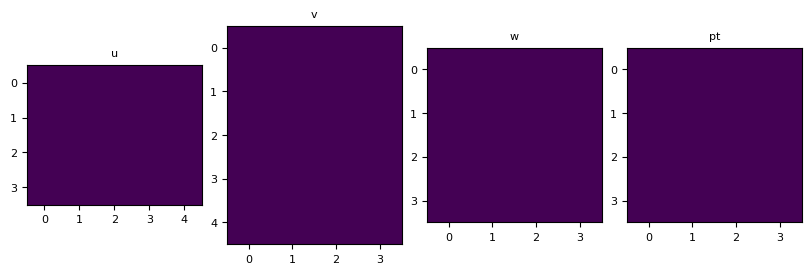

In [13]:
if mpi_rank == 0:
    # for k in range(80):
    k = -2
    plot_data(driver, k=k)
    plot_view(driver, k=k)

### Inside `if not self.config.hydrostatic`

In [14]:
self._halo_updaters.zh.wait()
self._compute_geopotential_stencil(
    self._zh,
    self._gz,
)
self._halo_updaters.pkc.wait()

### Inside `nonhydrostatic_pressure_gradient`

In [15]:
u = state.u 
v = state.v 
pp = self._pkc 
gz = self._gz
pk3 = self._pk3
delp = state.delp
dt = dt_acoustic_substep
ptop = self._ptop
akap = self._akap
self = self.nonhydrostatic_pressure_gradient

[output:0]

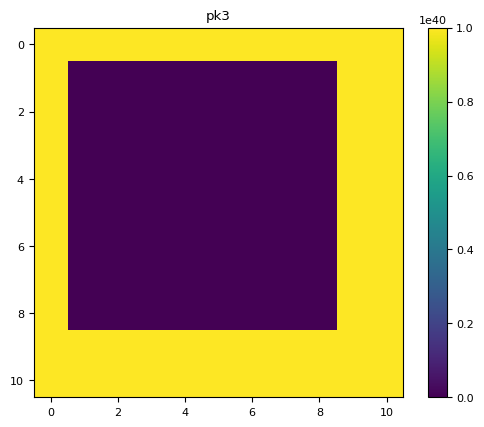

[output:0]

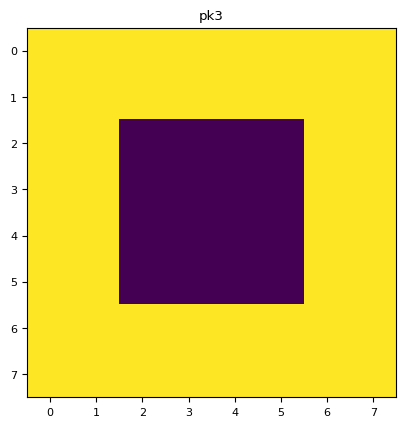

[output:0]

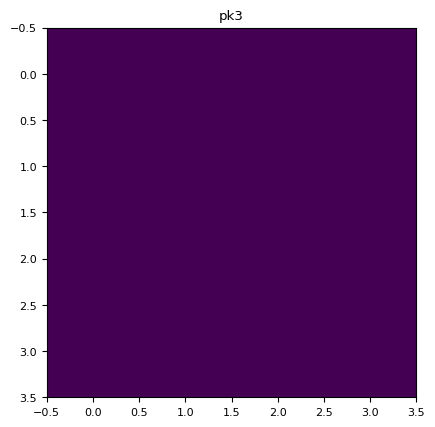

In [16]:
if mpi_rank == 0:    
    plt.imshow(pk3.data[:,:,-2])
    plt.title("pk3")
    plt.colorbar()

    plt.figure()
    plt.imshow(pk3.data[1:9,1:9,-2])
    plt.title("pk3")

    plt.figure()
    plt.imshow(pk3.data[3:7,3:7,-2])
    plt.title("pk3")

[output:0]

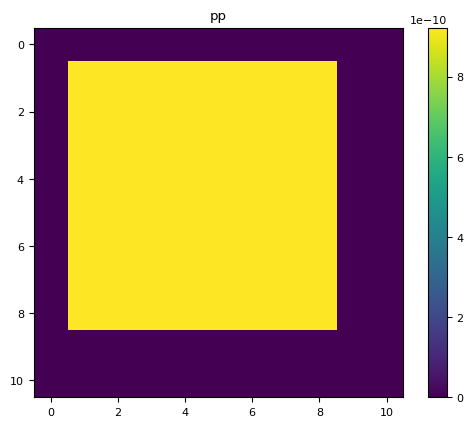

[output:0]

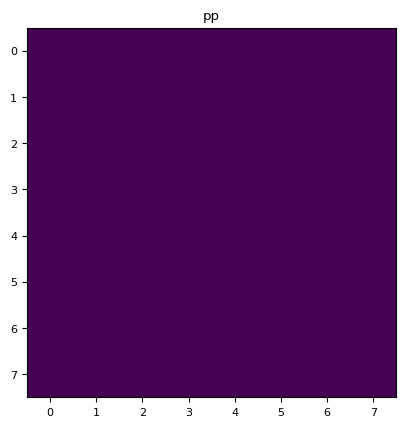

In [18]:
if mpi_rank == 0:    
    plt.imshow(pp.data[:,:,-2])
    plt.title("pp")
    plt.colorbar()

    plt.figure()
    plt.imshow(pp.data[1:9,1:9,-2])
    plt.title("pp")

[output:0]

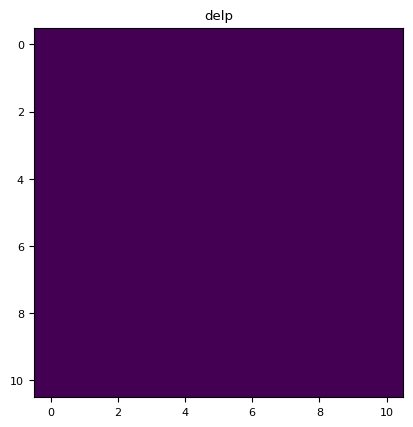

[output:0]

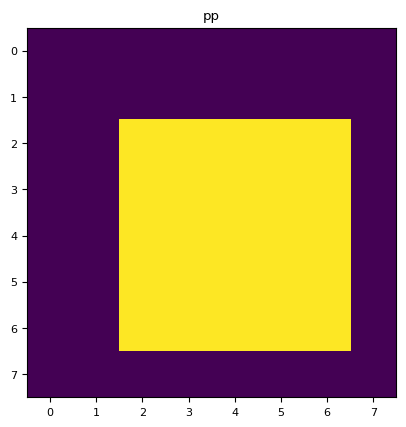

In [33]:
if mpi_rank == 0:    
    plt.imshow(delp.data[:,:,-2])
    plt.title("delp")

[output:0]

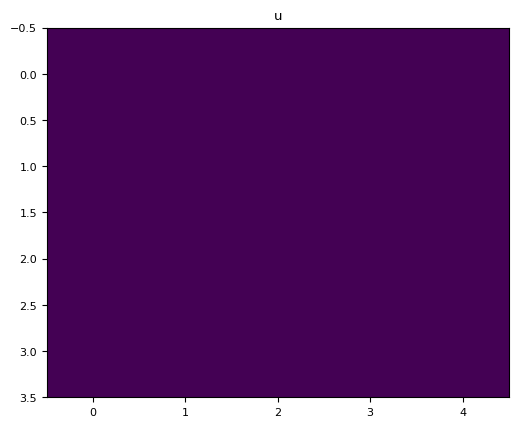

[output:0]

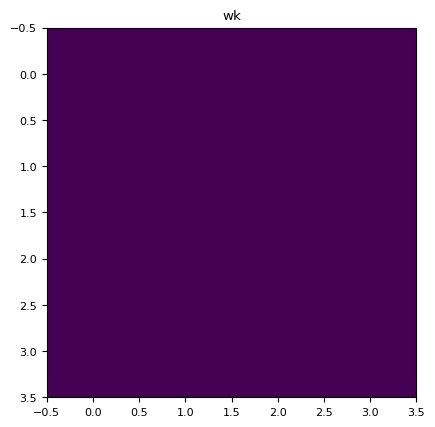

[output:0]

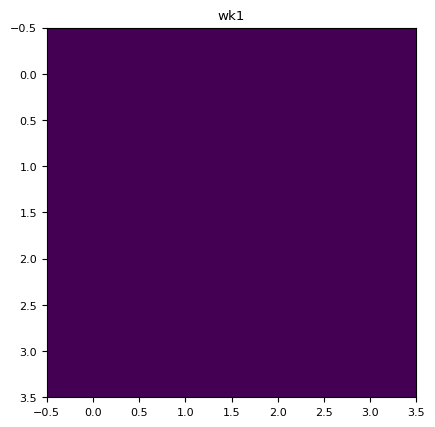

[output:0]

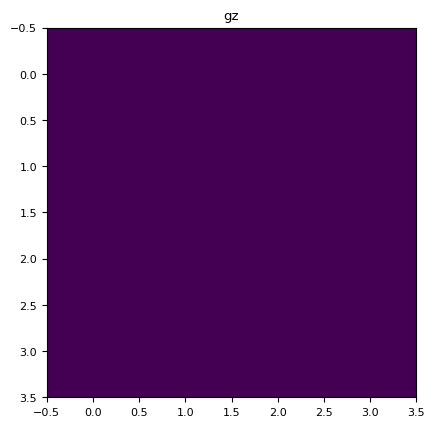

[output:0]

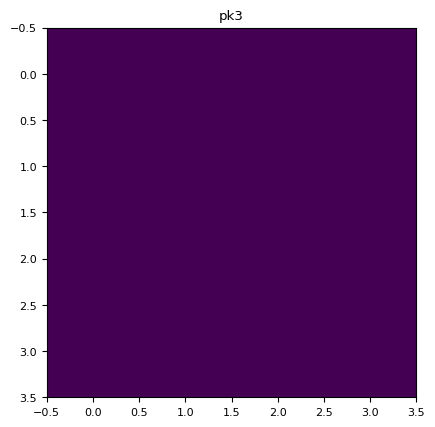

[output:0]

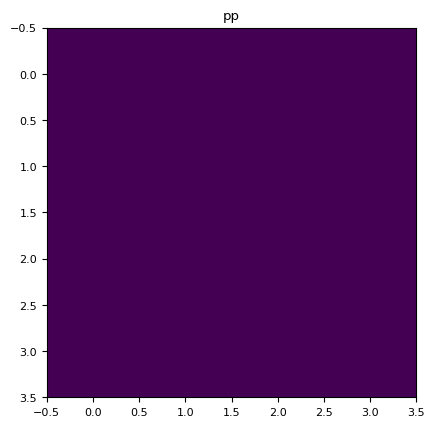

[output:0]

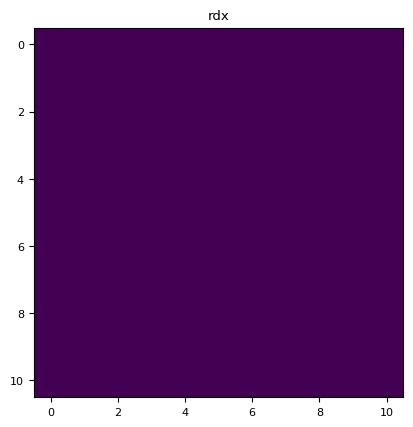

In [19]:
if mpi_rank == 0:
    plt.figure()
    plt.imshow(u.view[:,:,-2])
    plt.title("u")
    plt.figure()
    plt.imshow(self._tmp_wk.view[:,:,-2])
    plt.title("wk")
    plt.figure()
    plt.imshow(self._tmp_wk1.view[:,:,-2])
    plt.title("wk1")
    plt.figure()
    plt.imshow(gz.view[:,:,-2])
    plt.title("gz")
    plt.figure()
    plt.imshow(pk3.view[:,:,-2])
    plt.title("pk3")
    plt.figure()
    plt.imshow(pp.view[:,:,-2])
    plt.title("pp")
    plt.figure()
    plt.imshow(self._rdx)
    plt.title("rdx")

In [20]:
# Fortran names:
# u=u v=v pp=pkc gz=gz pk3=pk3 delp=delp dt=dt

ptk = ptop ** akap
top_value = ptk  # = peln1 if spec.namelist.use_logp else ptk

# TODO: make it clearer that each of these a2b outputs is updated
# instead of the output being put in tmp_wk1, possibly by removing
# the second argument and using a temporary instead?
self.a2b_k1(pp, self._tmp_wk1)
self.a2b_k1(pk3, self._tmp_wk1)

self.a2b_kbuffer(gz, self._tmp_wk1)
self.a2b_kstandard(delp, self._tmp_wk1)

[output:0]

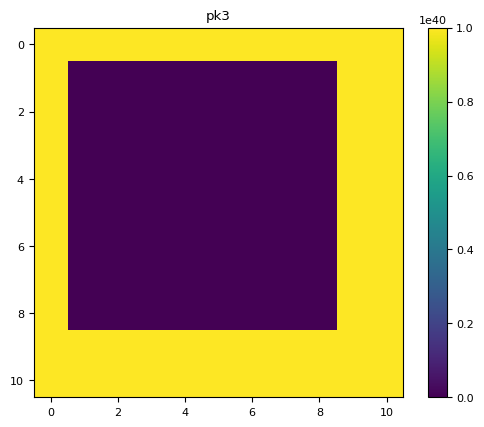

[output:0]

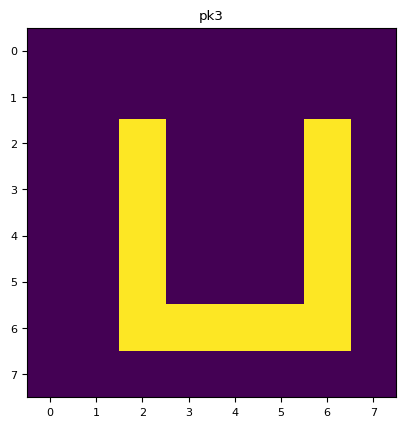

[output:0]

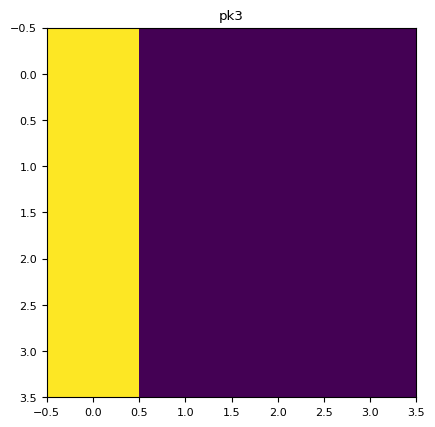

In [21]:
if mpi_rank == 0:    
    plt.imshow(pk3.data[:,:,-2])
    plt.title("pk3")
    plt.colorbar()

    plt.figure()
    plt.imshow(pk3.data[1:9,1:9,-2])
    plt.title("pk3")

    plt.figure()
    plt.imshow(pk3.data[3:7,3:7,-2])
    plt.title("pk3")

[output:0]

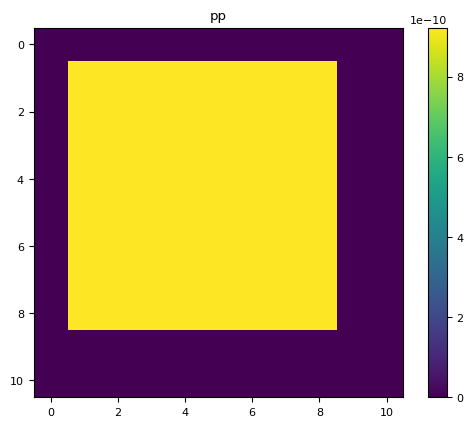

[output:0]

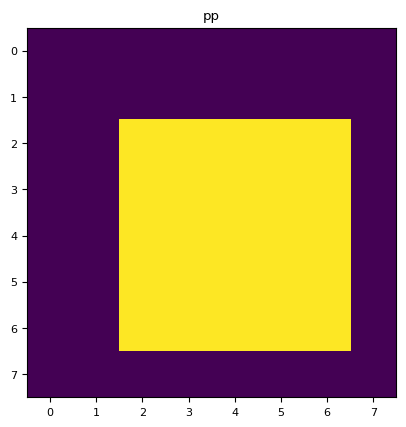

[output:0]

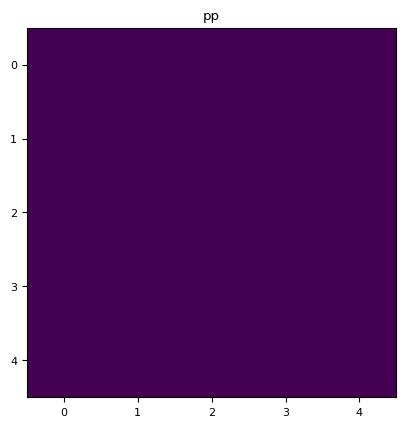

In [22]:
if mpi_rank == 0:    
    plt.imshow(pp.data[:,:,-2])
    plt.title("pp")
    plt.colorbar()

    plt.figure()
    plt.imshow(pp.data[1:9,1:9,-2])
    plt.title("pp")

    plt.figure()
    plt.imshow(pp.data[3:8,3:8,-2])
    plt.title("pp")

[output:0]

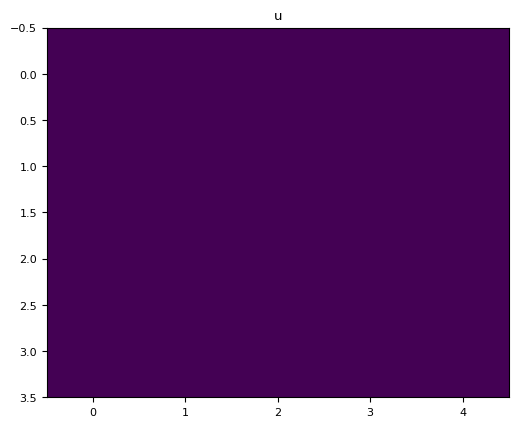

[output:0]

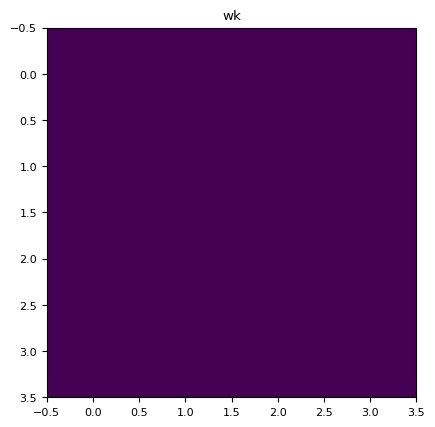

[output:0]

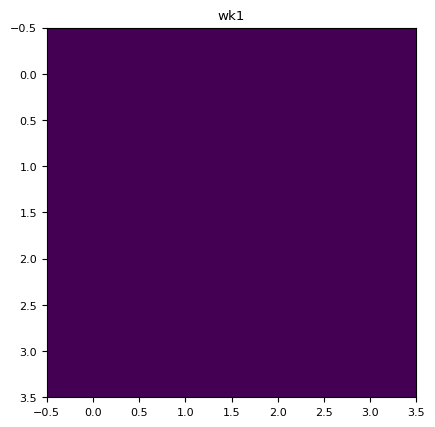

[output:0]

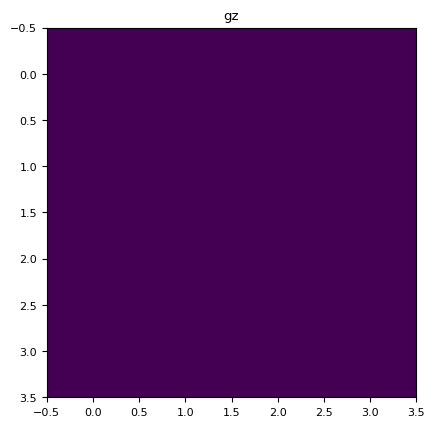

[output:0]

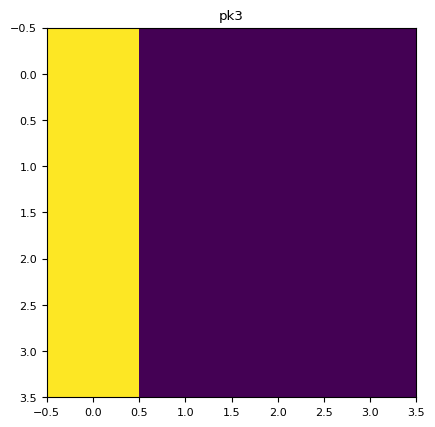

[output:0]

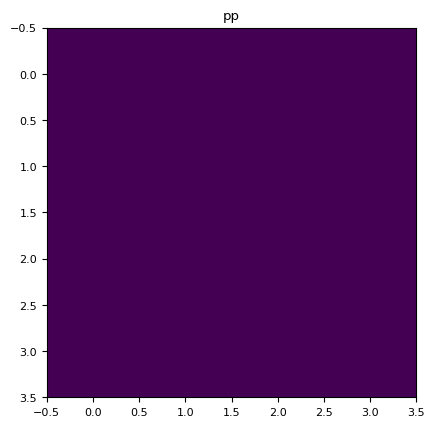

[output:0]

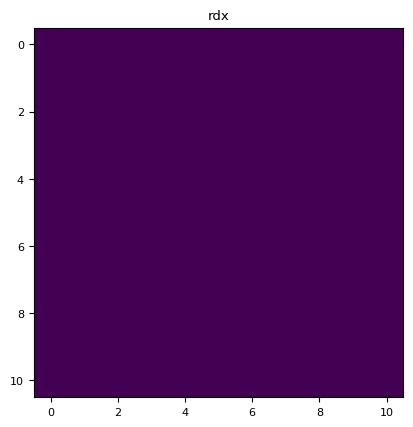

In [23]:
if mpi_rank == 0:
    plt.figure()
    plt.imshow(u.view[:,:,-2])
    plt.title("u")
    plt.figure()
    plt.imshow(self._tmp_wk.view[:,:,-2])
    plt.title("wk")
    plt.figure()
    plt.imshow(self._tmp_wk1.view[:,:,-2])
    plt.title("wk1")
    plt.figure()
    plt.imshow(gz.view[:,:,-2])
    plt.title("gz")
    plt.figure()
    plt.imshow(pk3.view[:,:,-2])
    plt.title("pk3")
    plt.figure()
    plt.imshow(pp.view[:,:,-2])
    plt.title("pp")
    plt.figure()
    plt.imshow(self._rdx)
    plt.title("rdx")

In [24]:
self._set_k0_and_calc_wk_stencil(pp, pk3, self._tmp_wk, top_value)

[output:0]

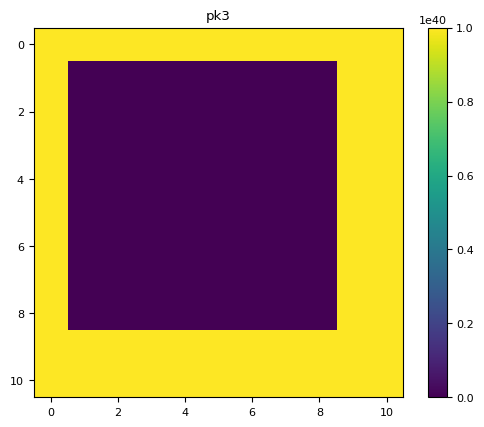

[output:0]

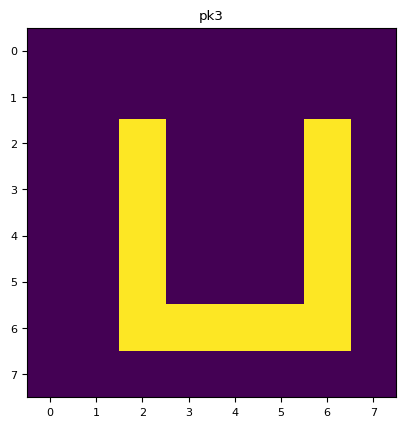

In [30]:
if mpi_rank == 0:    
    plt.imshow(pk3.data[:,:,-2])
    plt.title("pk3")
    plt.colorbar()

    plt.figure()
    plt.imshow(pk3.data[1:9,1:9,-2])
    plt.title("pk3")

[output:0]

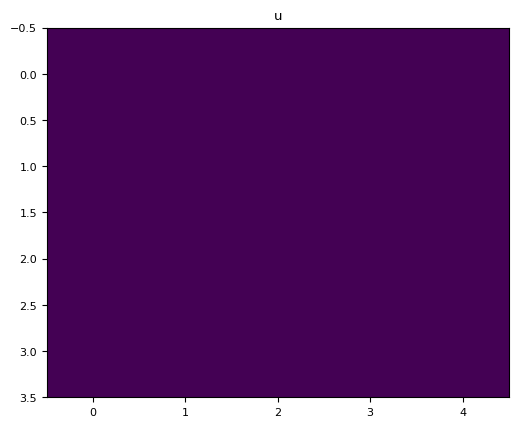

[output:0]

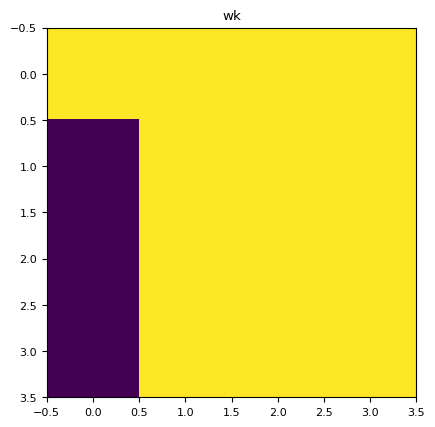

[output:0]

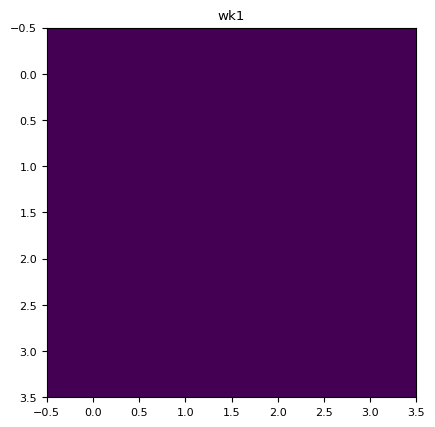

[output:0]

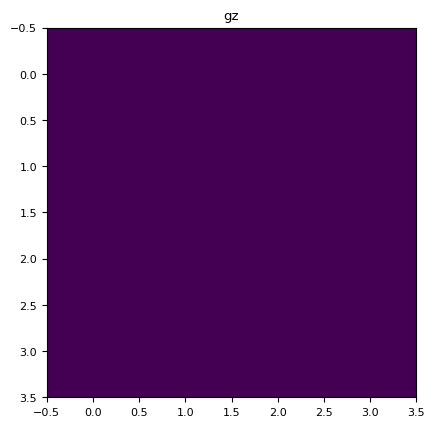

[output:0]

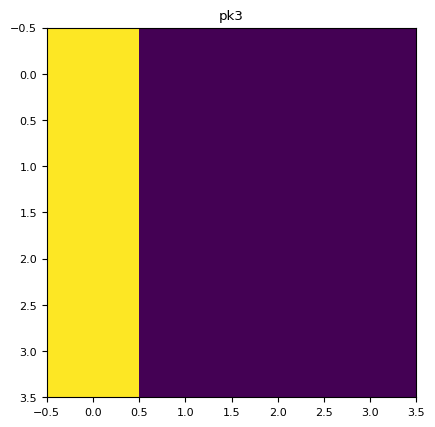

[output:0]

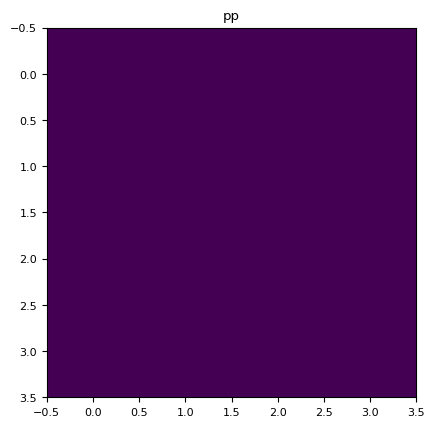

[output:0]

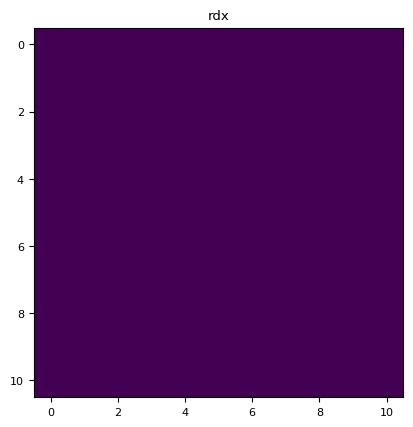

In [26]:
if mpi_rank == 0:
    plt.figure()
    plt.imshow(u.view[:,:,-2])
    plt.title("u")
    plt.figure()
    plt.imshow(self._tmp_wk.view[:,:,-2])
    plt.title("wk")
    plt.figure()
    plt.imshow(self._tmp_wk1.view[:,:,-2])
    plt.title("wk1")
    plt.figure()
    plt.imshow(gz.view[:,:,-2])
    plt.title("gz")
    plt.figure()
    plt.imshow(pk3.view[:,:,-2])
    plt.title("pk3")
    plt.figure()
    plt.imshow(pp.view[:,:,-2])
    plt.title("pp")
    plt.figure()
    plt.imshow(self._rdx)
    plt.title("rdx")

[output:0]

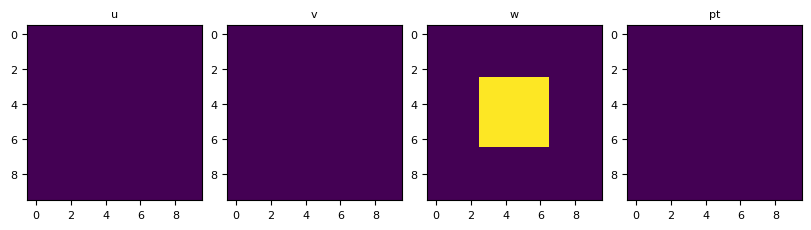

In [27]:
if mpi_rank == 0:
    k = -2
    plot_data(driver, k=k)

In [28]:
self._calc_u_stencil(
    u,
    self._tmp_wk,
    self._tmp_wk1,
    gz,
    pk3,
    pp,
    self._rdx,
    dt,
)

[output:0]

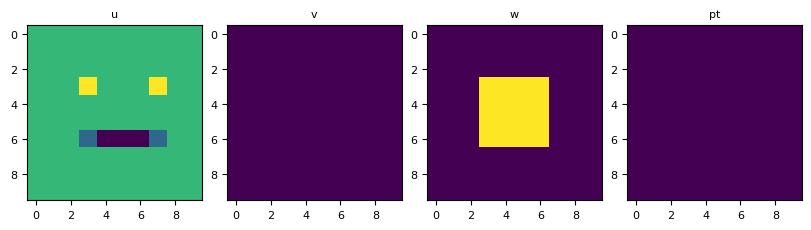

In [29]:
if mpi_rank == 0:
    k = -2
    plot_data(driver, k=k)